#  Summary

## 🔹 Conclusion:

* **The signal return has a strong correlation with respect to SPY daily return, while the lag order may change over time. Therefore, we need to first determine the proper lag(in days), then predict the coming day's SPY future price movement and make trading decisions.**

* **Preliminary analysis reveals that the proper lag is 2 before around 2013-03-21, and mostly 5 after.**

* **There exist some shortcomings though. The first problem is outliers which make the signal noisy. Another is   the forecast horizon (i.e. lag) may change, which requires an efficient detection method in order to avoid big loss.**

### Recommendations of how to use the signal:

* **Use z-score and mannul reasonning to detect outliers.**

* **Select the optimal lag and reliability in rolling windows. Trade based on prediction when the predictive power is strong enough.**

* **Watch out fot the correlation level. If it is getting smaller, the strategy may need adjustment in the coming days(lag, rolling window size, moving average, etc.).**


## 🔹 Analysis process:
   
   [Exploratory Analysis](#EA)
   
   [Data Cleaning](#DC)
   
   [Identify Forecast Horizon](#IFH)
   
   [Evaluation of Validity](#EV)   

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn')
import seaborn as sns
from sklearn.linear_model import LinearRegression
from scipy.stats import mstats
from sklearn import preprocessing
import warnings
warnings.filterwarnings("ignore")

In [2]:
data_original = pd.read_excel('ResearchDatasetV2.0.xlsx')

 <a id='EA'></a>

# 🔸  Exploratory analysis 

In [3]:
# Look at the distribution
def view_dist(data, columns, title='Distribution'):
    fig, axes = plt.subplots(1,len(columns), figsize=(16,3))
    fig.suptitle(title, size=16)
    for i in range(len(columns)):
        sns.distplot(data[columns[i]], ax=axes[i], label=columns[i])
        axes[i].tick_params(labelsize=12)
        axes[i].set_ylabel('Density')
        axes[i].legend(fontsize=12)

In [4]:
# Flag the top and bottom percentiles
def get_extreme_idx(data, columns, low_q=0.5, high_q=0.5):
    extreme_idx = pd.DataFrame(columns=columns)
    for col in columns:
        x = data[col]
        extreme_idx[col] = (x<np.percentile(x,low_q))|(x>np.percentile(x,100-high_q))
    return extreme_idx

In [5]:
# Visulization function
def view_mark(data, columns, outlier_idx=None, title=''):
    kw = dict(marker='o', linestyle='none', color='r', alpha=0.3)
    fig, axes = plt.subplots(len(columns), 1, figsize=(16,len(columns)*3), constrained_layout=True)
    fig.suptitle(title, size=16)
    fig.subplots_adjust(top=0.95)
    for i in range(len(columns)):
        data[columns[i]].plot(label=columns[i], ax=axes[i], linewidth=1)
        if outlier_idx is not None:
            data[columns[i]][outlier_idx[columns[i]]].plot(**kw, ax=axes[i],label='Outlier')
        #axes[i].set_title(columns[i], fontsize=14)
        axes[i].legend(fontsize=12)
        axes[i].tick_params(labelsize=12)

In [6]:
# Reduce the effect of possibly spurious outliers by limiting the extreme values
def winsorize(data, columns, low_pct=0.01, high_pct=0.01):
    for col in columns:
        data[col] = mstats.winsorize(data[col], limits=[low_pct, high_pct])
    return data

### Look into index & column dtypes, non-null values and memory usage.

In [7]:
data_original.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 667 entries, 0 to 666
Data columns (total 3 columns):
Date          667 non-null int64
Signal        667 non-null float64
ClosePrice    667 non-null float64
dtypes: float64(2), int64(1)
memory usage: 15.7 KB


* **No missing values, good!** ⬆️
* **The dtype of 'Date' column is int64, need transformation.** ⬇️

### Convert 'Date' to datetime. View some basic statistical details.

In [8]:
data_original['Date'] = data_original.Date.apply(lambda x: pd.to_datetime(str(x)))

In [9]:
data_original.set_index('Date', inplace=True)

In [10]:
data_original.describe().T

,count,mean,std,min,25%,50%,75%,max
Signal,667.0,5.166802,23.392809,-3.80267,3.418083,3.893689,4.408313,432.961165
ClosePrice,667.0,163.169369,39.210384,127.49500,140.880000,159.750000,181.500000,710.310000


### View distributions, check outliers

* **Look into the return**

In [11]:
data_original['SPYReturn'] = (data_original.ClosePrice/data_original.ClosePrice.shift(1)).fillna(1)-1
data_original['SignalReturn'] = (data_original.Signal/data_original.Signal.shift(1)).fillna(1)-1

In [12]:
data_original.head()

,Signal,ClosePrice,SPYReturn,SignalReturn
Date,,,,
2012-01-03,3.107767,127.495,0.000000,0.000000
2012-01-04,3.107282,127.700,0.001608,-0.000156
2012-01-05,3.099757,128.040,0.002662,-0.002421
2012-01-06,3.134223,127.710,-0.002577,0.011119
2012-01-09,3.135922,128.020,0.002427,0.000542


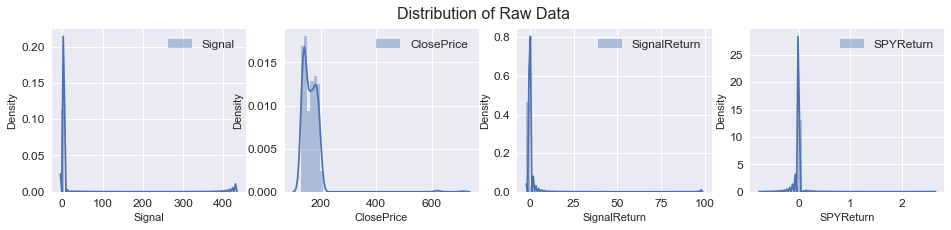

In [13]:
columns = ['Signal','ClosePrice', 'SignalReturn','SPYReturn']
view_dist(data_original, columns=columns, title='Distribution of Raw Data')

* **Both variables have ourliers, let's mark them and then winsorize.**

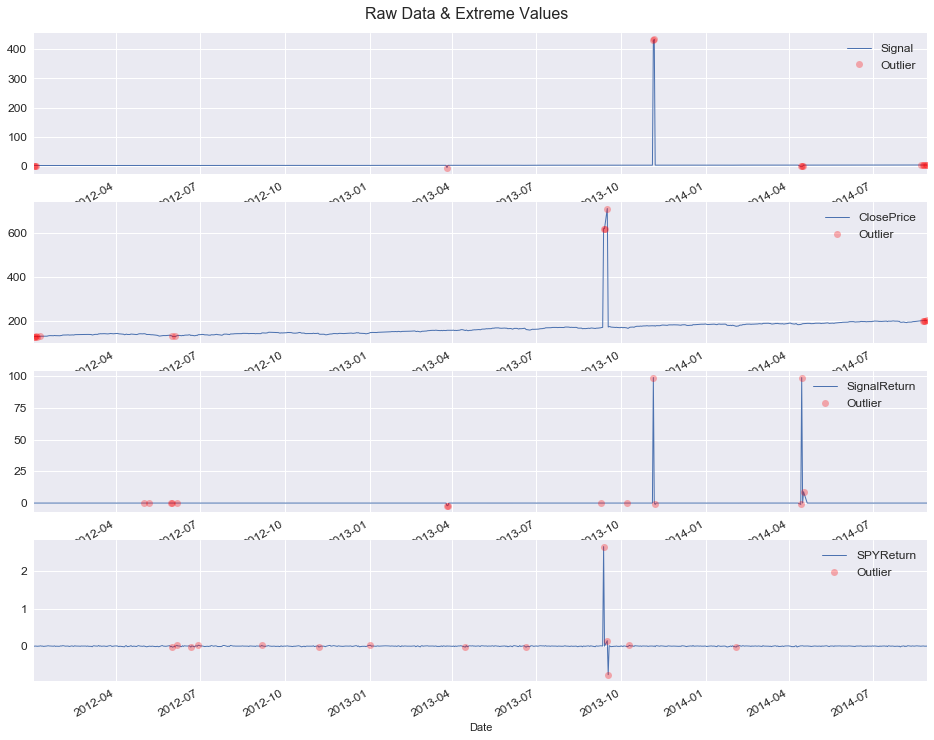

In [14]:
columns = ['Signal','ClosePrice', 'SignalReturn','SPYReturn']
extreme_idx = get_extreme_idx(data_original, columns, low_q=1, high_q=1)
view_mark(data_original.copy(), columns, extreme_idx, 'Raw Data & Extreme Values')

* **The extreme values happen at different time. It is likely to be caused by technical/recording issue.** ⬆️

* **Try winsorizing the lowest and highest 1%, the distributions become more concentrated and symetric.**⬇️

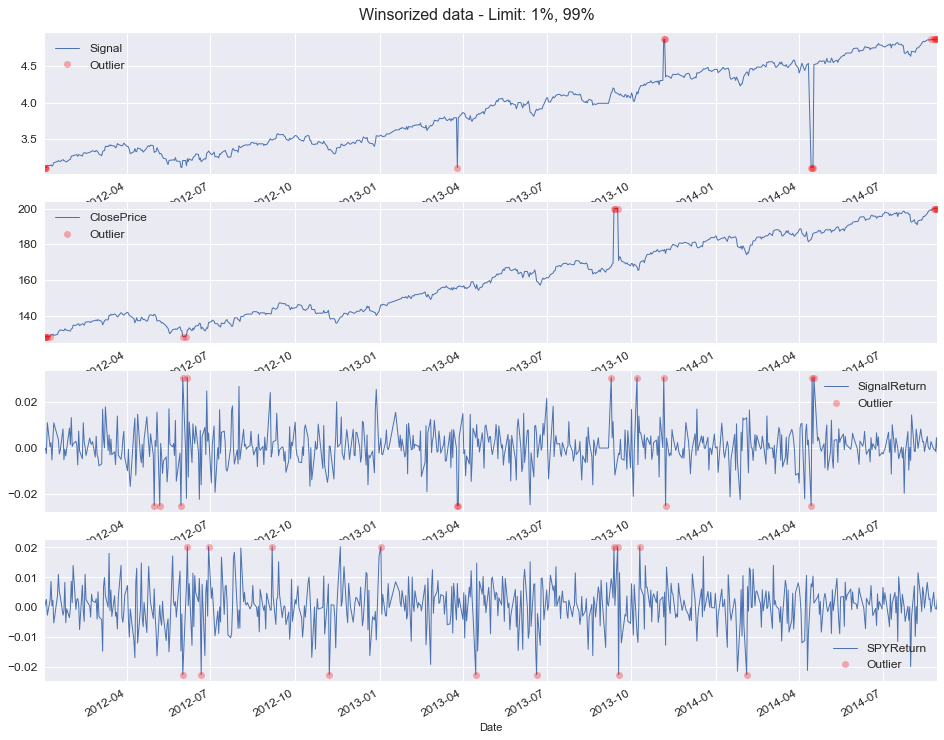

In [15]:
view_mark(winsorize(data_original.copy(), columns, 0.01, 0.01), 
          columns, extreme_idx, 'Winsorized data - Limit: 1%, 99%')

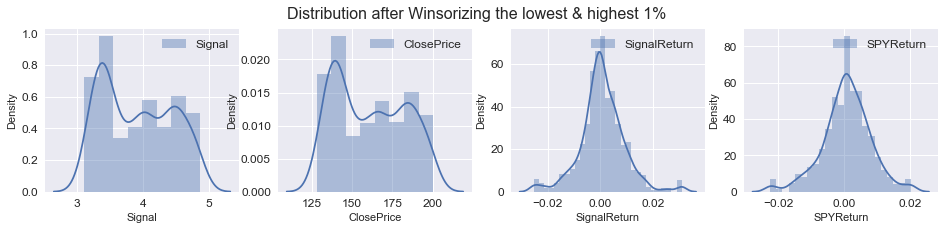

In [16]:
view_dist(winsorize(data_original.copy(), columns, 0.01, 0.01), columns=columns, title='Distribution after Winsorizing the lowest & highest 1%')

* **Look into a small part first, let's try the first 100 items.** ⬇️

In [17]:
def compare(data, columns):
    fig, ax = plt.subplots(1,1, figsize=(16,4))
    for i in range(len(columns)):        
        plt.plot(data[columns[i]], label=columns[i])
    ax.legend(fontsize=12)
    ax.set_title('Standardized values', fontsize=15)
#     ax.set_ylim((-2,2))

In [18]:
columns=['Signal','ClosePrice']
data_win = winsorize(data_original.copy(), data_original.columns, 0.01, 0.01)
data_sc = pd.DataFrame(preprocessing.StandardScaler().fit_transform(data_win), columns=data_win.columns, index=data_original.index)

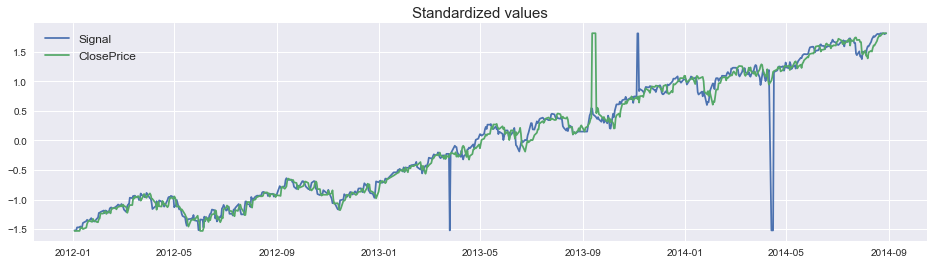

In [19]:
low_bound = 0
high_bound = 100
compare(data_sc, columns)

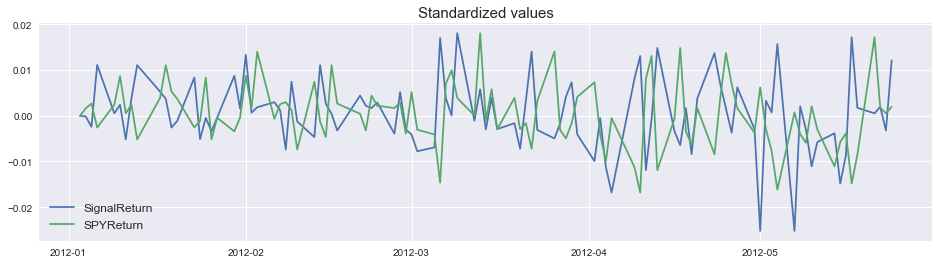

In [20]:
compare(data_win.iloc[low_bound:high_bound], columns=['SignalReturn','SPYReturn'])

* **The trends seem in line but there seem to have some shifts.**


### Multiple time series auto regression (VAR)

* **The goal of this step is to get a sense of which lag has predictive power**

In [21]:
from statsmodels.tsa.vector_ar.var_model import VAR

model = VAR(data_win[['SignalReturn','SPYReturn']].dropna())
res = model.fit(6)
res.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 13, Jan, 2020
Time:                     10:49:26
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -19.4940
Nobs:                     661.000    HQIC:                  -19.6023
Log likelihood:           4651.35    FPE:                2.86481e-09
AIC:                     -19.6708    Det(Omega_mle):     2.75536e-09
--------------------------------------------------------------------
Results for equation SignalReturn
                     coefficient       std. error           t-stat            prob
----------------------------------------------------------------------------------
const                   0.000957         0.000343            2.787           0.005
L1.SignalReturn        -0.093153         0.039288           -2.371           0.018
L1.SPYReturn            0.108829         0.05

### Explore the charts

* **Plot out the variables based on the suggested shifts. A mannual process is helpful in the case of small data size.** ⬇️

In [22]:
def try_shift(shift, low_bound=0, high_bound=100):
    # Specifically for standardized "Return" and "SignalReturn"
    columns = ['SignalReturn', 'SPYReturn']
    data_shifted = pd.DataFrame(columns=columns)
    data_shifted[columns[0]] = data_win[columns[0]].iloc[low_bound:high_bound].values
    data_shifted[columns[1]] = data_win[columns[1]].iloc[low_bound+shift:high_bound+shift].values
    compare(data_shifted, columns)

* **Lag 2** 

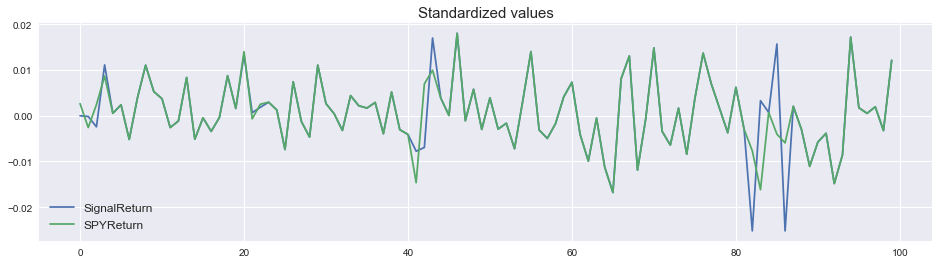

In [23]:
try_shift(2,0,100) # Awesome!

* **Lag 3** 

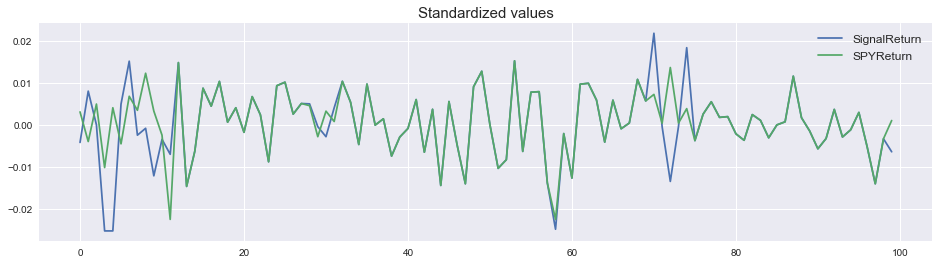

In [24]:
try_shift(5,300,400) 

* **Lag 5**  ⬇️

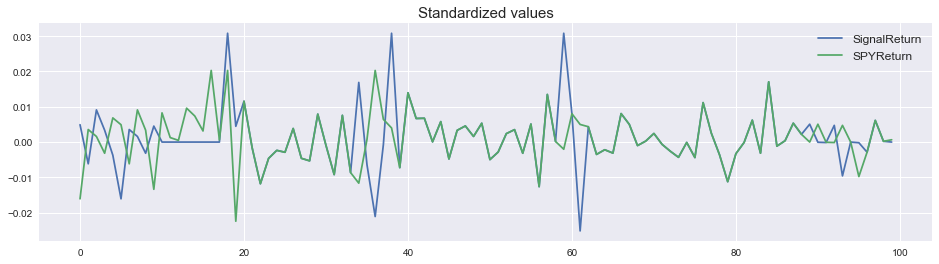

In [25]:
try_shift(5,400, 500) 

## Zoom in

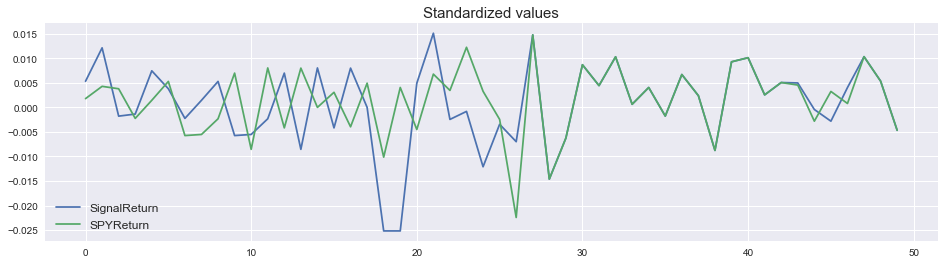

In [26]:
try_shift(5,285,335) # Some more

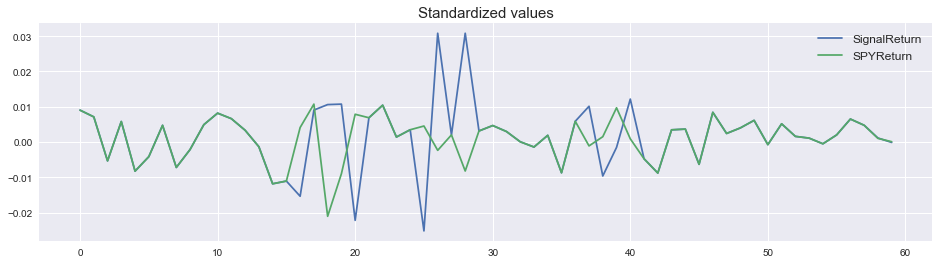

In [27]:
try_shift(5,545,605) 

 <a id='DC'></a>
# 🔸 Data Cleaning

### Standardize and removing outliers (out of 4$\sigma$)
* **It is revealed from previous plots that the two variables have different magnitudes.**
* **Standardize the variables by removing the mean and scaling to unit variance for the convenience of comparison.** 
* **Use expanding method. The first 100 datapoints are assumed to be known. Start from the 101st, every current mean and variance depend on all&only previous datapoints(imagine we do the calculation after market close).** ⬇️
* **Correct them by setting the value as the previous datapoint, since it is the latest infomation we already know.**

In [28]:
import scipy.stats as st
st.norm.cdf(4)

0.9999683287581669

### Standard scaling, detect outliers and correct

* **Raw data: set as the prior value.**

* **Standardized data: set as the threshold**

In [29]:
data = data_original.copy()

columns = ['Signal','ClosePrice','SignalReturn','SPYReturn']
low_q, high_q = 0.00, 0.00
threshold = 4

# Scaled data
data_sc = pd.DataFrame(columns=columns, index=data.index)
outlier_idx = pd.DataFrame(columns=columns, index=data.index)

for col in columns:
    temp = preprocessing.StandardScaler().fit_transform(data[col][:100].values.reshape(-1,1)).reshape(1,-1)[0]
    for i in range(100):
        data_sc[col][i] = temp[i]
        outlier_idx[col][i] = abs(temp[i]) > threshold
        if outlier_idx[col][i]:
            #data[col][i] = np.quantile(data[col][:100],low_q) if temp[i]<0 else np.quantile(data[col][:100],1-high_q)
            data[col][i] = data[col][i-1]
            data_sc[col][i] = temp[i]/abs(temp[i])*threshold
    for i in range(100, len(data_original)):
        temp = preprocessing.StandardScaler().fit(data[col][:i].values.reshape(-1,1)).transform(np.array([[data[col][i]]]))[0][0]
        data_sc[col][i] = temp
        outlier_idx[col][i] = abs(temp) > threshold 
        if outlier_idx[col][i]:
            #data[col][i] = np.quantile(data[col][:i],low_q) if temp[i]<0 else np.quantile(data[col][:i],1-high_q)
            data[col][i] = data[col][i-1]
            data_sc[col][i] =  temp/abs(temp)*threshold

### Zoom in to check the outliers. They are highly possible caused by technichal errors. Thus mannuly correct them again.

* **Signal: correct the sign and decimal point position.**

* **SPY Close Price: replace with the right number(available online)**

In [30]:
data_original[outlier_idx.apply(any, axis=1)]

,Signal,ClosePrice,SPYReturn,SignalReturn
Date,,,,
2013-03-26,-3.802670,156.1900,0.008003,-2.003073
2013-03-27,3.787621,156.1900,0.000000,-1.996043
2013-09-09,4.133738,167.6340,0.009600,0.036012
2013-09-12,4.193204,618.9500,2.653778,-0.001682
2013-09-13,4.143689,619.3300,0.000614,-0.011808
2013-09-16,4.124515,710.3100,0.146901,-0.004627
2013-09-17,4.114806,171.0700,-0.759161,-0.002354
2013-11-05,429.514563,176.2700,-0.003167,98.796977
2013-11-06,432.961165,177.1700,0.005106,0.008024


In [31]:
data.loc['2013-03-26']['Signal'] = data_original.loc['2013-03-26']['Signal'] * -1
data.loc['2013-11-05']['Signal'] = data_original.loc['2013-11-05']['Signal'] / 100
data.loc['2013-11-06']['Signal'] = data_original.loc['2013-11-06']['Signal'] / 100
data.loc['2014-04-14']['Signal'] = data_original.loc['2014-04-14']['Signal'] * 1000
data.loc['2014-04-15']['Signal'] = data_original.loc['2014-04-15']['Signal'] * 10
data.loc['2014-04-16']['Signal'] = data_original.loc['2014-04-16']['Signal'] * 10

data.loc['2013-09-12']['ClosePrice'] = 168.95
data.loc['2013-09-13']['ClosePrice'] = 169.33
data.loc['2013-09-16']['ClosePrice'] = 170.31

In [32]:
data['SPYReturn'] = (data.ClosePrice/data.ClosePrice.shift(1)).fillna(1)-1
data['SignalReturn'] = (data.Signal/data.Signal.shift(1)).fillna(1)-1

### After correcting outliers 🌟🌟 

In [33]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
Signal,667.0,3.917188,0.524491,3.099757,3.421966,3.914369,4.410012,4.881311
ClosePrice,667.0,161.010448,21.427182,127.495000,140.880000,159.750000,181.060000,200.710000
SPYReturn,667.0,0.000707,0.007303,-0.025177,-0.003167,0.000728,0.005062,0.025630
SignalReturn,667.0,0.000706,0.008047,-0.026902,-0.003303,0.000080,0.005069,0.036012


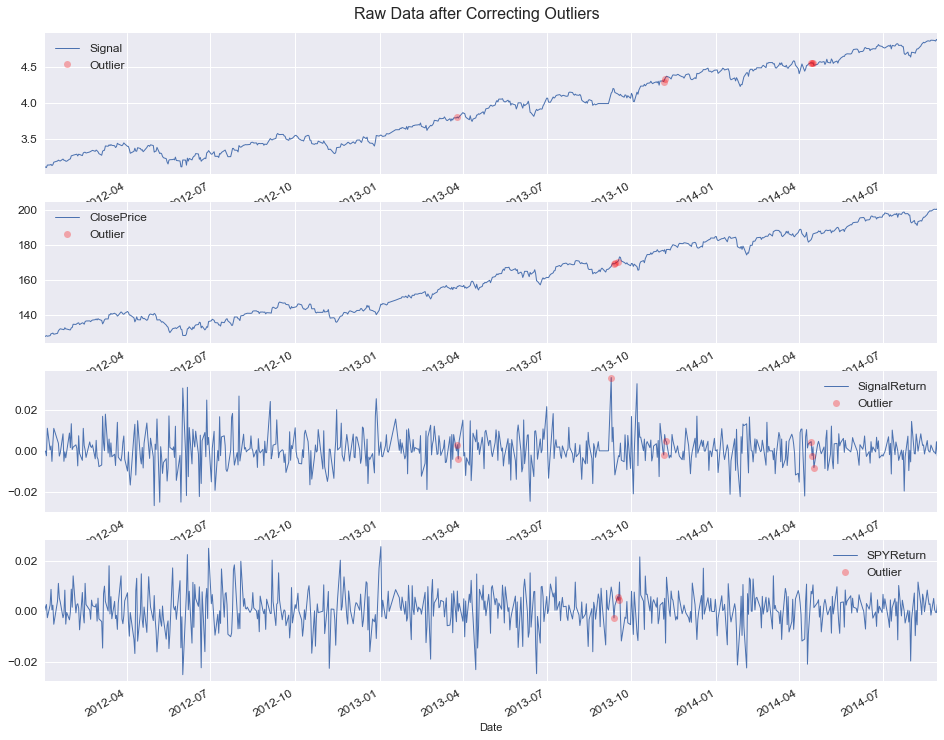

In [34]:
view_mark(data, columns, outlier_idx, 'Raw Data after Correcting Outliers')

In [35]:
# view_mark(data_sc, columns, outlier_idx, 'Standardized Values after Removing Outliers')

 <a id='IFH'></a>
# 🔸 Identify Forecast Horizon

### Select the optimal lag by calculating lagged correlations in rolling windows
* **On each day and for each lag candidate, calculate the correlation between lagged signal return and SPY_return in a specific window. Take the average of previous n correlations, the optimal lag would be the one with largest absolute avg_corr (all positive here).**
* **This optimal lagged signal return is used to forecast the current day's SPY_return** ⬇️


In [36]:
def optimal_lag(indicator, target, lags, n=3, window=22):
    corrs = pd.Series(index=target.index)
    avg_corr = {}
    for l in lags:
        corrs = []
        for i in range(len(target)-l-window-n, len(target)-l-window):
            corrs.append(np.corrcoef(indicator[i:i+window].values, target[i+l:i+window+l].values, ddof=1))
        avg_corr[l] = np.mean(corrs)
    return pd.Series(avg_corr)

In [37]:
lags = list(range(1,9)) #candidate lags
max_lag = max(lags)
n = 3 # moving average
window = 22 # rolling window
indicator = 'SignalReturn'
target = 'SPYReturn'

scores = pd.DataFrame(columns=lags, index=data[target].index)
for i in range(100, len(data[target])):
    scores.loc[data[target].index[i]] = optimal_lag(data[indicator][i-window-n-max_lag:i],
                                                 data[target][i-window-n-max_lag:i], lags, n, window)

In [38]:
scores['Highest_corr'] = scores.apply(lambda x: x.astype(float).abs().max(), axis=1)
scores['Optimal_lag'] = scores.apply(lambda x: x.astype(float).abs().idxmax(), axis=1)

* **Visualize the result. Compare with the standardized prices and returns** ⬇️
* **There is no obvious pattern when the optimal lag changes.** 

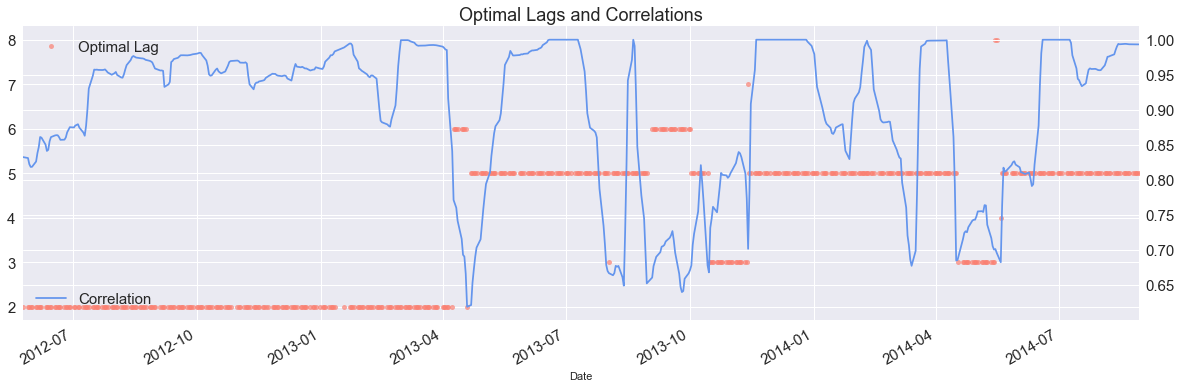

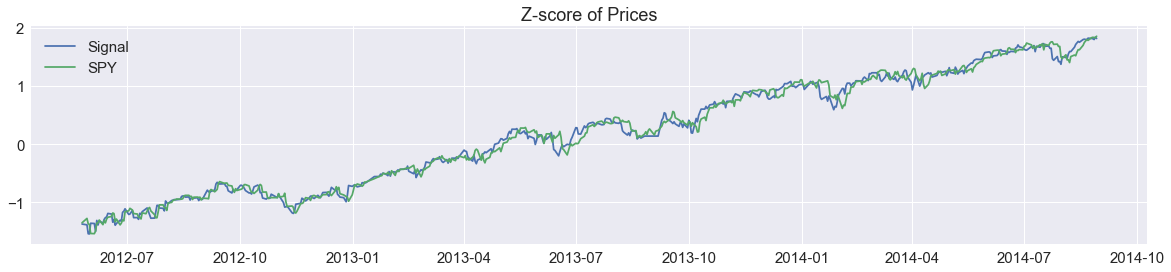

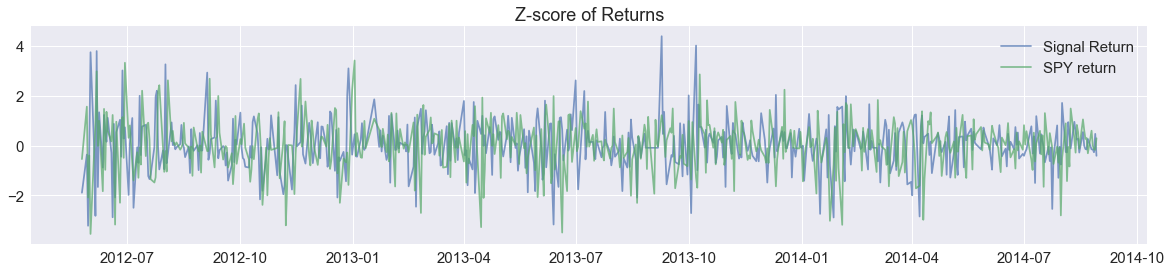

In [39]:
fig, ax1 = plt.subplots(figsize=(20,6))
scores['Optimal_lag'].dropna().plot(marker='o', linestyle='none', color='salmon', alpha=0.7, markersize=5, ax=ax1, label='Optimal Lag')
ax2 = ax1.twinx() 
ax2.plot(scores.dropna().Highest_corr, label='Correlation', color='cornflowerblue')
ax1.set_title('Optimal Lags and Correlations', fontsize=18)
ax1.legend(fontsize=15)
ax2.legend(fontsize=15)
ax1.tick_params(labelsize=15)
ax2.tick_params(labelsize=15)

data_sc = pd.DataFrame(preprocessing.StandardScaler().fit_transform(data), columns=data.columns, index=data.index)

plt.figure(figsize = (20, 4))
plt.plot(data_sc.iloc[100:]['Signal'], label = 'Signal')
plt.plot(data_sc.iloc[100:]['ClosePrice'], label = 'SPY')
plt.legend(fontsize=15)
plt.title('Z-score of Prices', fontsize=18)
plt.tick_params(labelsize=15)


plt.figure(figsize = (20, 4))
plt.plot(data_sc.iloc[100:]['SignalReturn'], label = 'Signal Return', alpha=0.7)
plt.plot(data_sc.iloc[100:]['SPYReturn'], label = 'SPY return', alpha=0.7)
plt.legend(fontsize=15)
plt.title('Z-score of Returns', fontsize=18)
plt.tick_params(labelsize=15)

 <a id='EV'></a>
# 🔸 Evaluate Validity

### A simple backtest based on the prediction. Take long position when predicted return is posive and short position when nective. Close out when the predition is unreliable. We can also adjust the position size based on the predicted return size.

* **For simplicity, do not consider transaction cost/turnover issue.**
* **On each day, take a unit long position when predicted return is posive and a short position when negative.**
* **When the correlation is below 0.75, close out because the predictive power becomes weak, there might be a potential switch of the lag.**


In [41]:
scores['Return'] = None
for i in range(100,len(scores)):
    if scores['Highest_corr'][i] > 0.75: 
        scores['Return'][i] = data_original['SPYReturn'][i]*np.sign(data_original['SignalReturn'][i-int(scores['Optimal_lag'][i])])
scores['CumReturn'] = scores['Return'].cumsum()

In [42]:
scores.tail()

,1,2,3,4,5,6,7,8,Highest_corr,Optimal_lag,Return,CumReturn
Date,,,,,,,,,,,,
2014-08-25,0.619045,0.613211,0.561212,0.469244,0.99332,0.507486,0.537151,0.602677,0.993320,5.0,0.00507054,1.98827
2014-08-26,0.620132,0.619235,0.565272,0.468263,0.993301,0.513362,0.532802,0.612853,0.993301,5.0,0.000649351,1.98892
2014-08-27,0.623579,0.622638,0.56823,0.464783,0.993327,0.512359,0.530914,0.622711,0.993327,5.0,0.000399341,1.98932
2014-08-28,0.617202,0.621769,0.565256,0.463099,0.993318,0.508811,0.534899,0.6251,0.993318,5.0,0.000549313,1.98987
2014-08-29,0.609144,0.633246,0.559885,0.462569,0.993312,0.50718,0.537918,0.631133,0.993312,5.0,0.00284801,1.99272


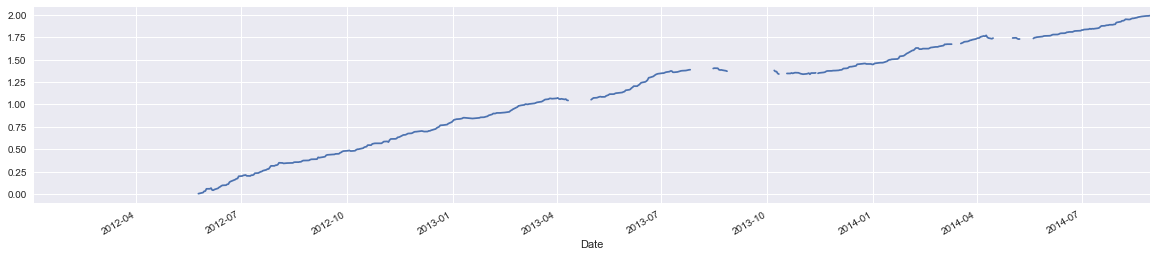

In [43]:
scores.CumReturn.plot(figsize=(20,4))

In [44]:
rf = 0.02
AnnualReturn = scores.Return.mean()*253
AnnualVol = scores.Return.std()*np.sqrt(253)
SharpeRatio = (AnnualReturn-rf)/AnnualVol

print('Annual Return: {0:.3f}'.format(AnnualReturn))
print('Annual Volatility: {0:.3f}'.format(AnnualVol))
print('Sharpe Ratio: {0:.3f}'.format(SharpeRatio))

Annual Return: 1.037
Annual Volatility: 0.099
Sharpe Ratio: 10.251
